In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import timeseries_dataset_from_array
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

import statsmodels.api as sm

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", 50)

## **Dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

CSV_PATH = '/content/drive/MyDrive/m5/111.csv'


DATE_COL = "Order Date"
PROFIT_COL = "Total Profit"

df = pd.read_csv(CSV_PATH)

print(df.head())
print(df.info())
print(df.describe())
print(df.columns)

df = df.dropna(subset=["Order Date", "Total Profit"])

df["Order Date"] = pd.to_datetime(df["Order Date"])


daily_profit = (
    df.groupby("Order Date")["Total Profit"]
    .sum()
    .reset_index()
)

daily_profit["Year"] = daily_profit["Order Date"].dt.year
daily_profit["Month"] = daily_profit["Order Date"].dt.month
daily_profit["Day"] = daily_profit["Order Date"].dt.day

print("Daily profit preview:")
print(daily_profit.head())

yearly_profit = (
    daily_profit.groupby("Year")["Total Profit"]
    .mean()
    .reset_index()
)

monthwise_profit = (
    daily_profit.groupby("Month")["Total Profit"]
    .mean()
    .reset_index()
)

daily_ts = (
    daily_profit
    .set_index(DATE_COL)[PROFIT_COL]
    .sort_index()
)

# ----------------------------
# Monthly resample
# ----------------------------

monthly = daily_ts.resample("M").sum().to_frame()
monthly.columns = ["profit"]
monthly["profit"] = monthly["profit"].astype(float)

bad_month = pd.to_datetime("2020-09-30")

if bad_month in monthly.index:
    print("\nFixing abnormal profit value on 2020-09-30:")
    print("Before fix:", monthly.loc[bad_month])

    # If October is missing, use only August and July to impute
    prev_val = monthly.loc[pd.to_datetime("2020-08-31"), "profit"]
    prev_prev_val = monthly.loc[pd.to_datetime("2020-07-31"), "profit"]

    # Impute using average of the previous two months
    imputed_val = (prev_val + prev_prev_val) / 2

    monthly.loc[bad_month, "profit"] = imputed_val

    print("After fix:", monthly.loc[bad_month])
else:
    print("\nSeptember 2020 not in dataset. No fix needed.")
print("Monthly profit preview:")
print(monthly.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                              Region     Country      Item Type Sales Channel  \
0              Australia and Oceania   Australia           Meat        Online   
1                               Asia  Tajikistan  Personal Care        Online   
2                 Sub-Saharan Africa  Mozambique      Cosmetics        Online   
3  Central America and the Caribbean      Panama  Personal Care       Offline   
4                      North America      Canada         Fruits        Online   

  Order Priority  Order Date   Order ID   Ship Date  Units Sold  Unit Price  \
0              C    4/4/2011  451691138   5/23/2011        4300      421.89   
1              L   7/12/2018  144177377    8/1/2018        4145       81.73   
2              H    7/6/2011  982716166   7/17/2011        6407      437.20   
3              L    5/1/2011  784543836   5/11/2011        2810     

/tmp/ipython-input-2507517879.py:57: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = daily_ts.resample("M").sum().to_frame()


(2000000, 14)


,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Order ID,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
0,Australia and Oceania,Australia,Meat,Online,C,2011-04-04,451691138,5/23/2011,4300,421.89,364.69,1814127.00,1568167.00,245960.00
1,Asia,Tajikistan,Personal Care,Online,L,2018-07-12,144177377,8/1/2018,4145,81.73,56.67,338770.85,234897.15,103873.70
2,Sub-Saharan Africa,Mozambique,Cosmetics,Online,H,2011-07-06,982716166,7/17/2011,6407,437.20,263.33,2801140.40,1687155.31,1113985.09
3,Central America and the Caribbean,Panama,Personal Care,Offline,L,2011-05-01,784543836,5/11/2011,2810,81.73,56.67,229661.30,159242.70,70418.60
4,North America,Canada,Fruits,Online,H,2013-11-15,137209212,12/29/2013,2110,9.33,6.92,19686.30,14601.20,5085.10


,count,mean,min,25%,50%,75%,max,std
Order Date,2000000,2015-05-06 15:59:29.356800,2010-01-01 00:00:00,2012-09-02 00:00:00,2015-05-06 00:00:00,2018-01-07 00:00:00,2020-09-10 00:00:00,NaN
Order ID,2000000.0,549828101.621702,100000321.0,325254272.75,549689614.0,774444031.0,999999892.0,259551419.600824
Units Sold,2000000.0,5001.290576,1.0,2502.0,5002.0,7500.0,10000.0,2886.686712
Unit Price,2000000.0,266.094345,9.33,81.73,154.06,421.89,668.27,216.98837
Unit Cost,2000000.0,187.573907,6.92,35.84,97.44,263.33,524.96,175.670061
Total Revenue,2000000.0,1330973.316179,9.33,278255.2,785670.49,1822249.6,6682700.0,1469702.487658
Total Cost,2000000.0,938207.062598,6.92,162065.42,467419.68,1196834.85,5249600.0,1149820.725694
Total Profit,2000000.0,392766.253581,2.41,95253.06,281741.0,565866.085,1738700.0,379253.311309


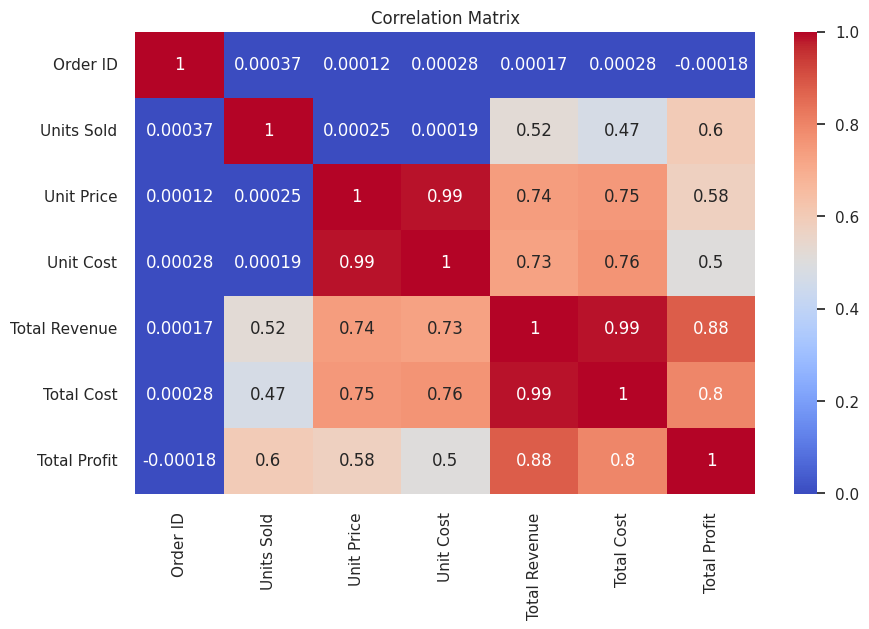

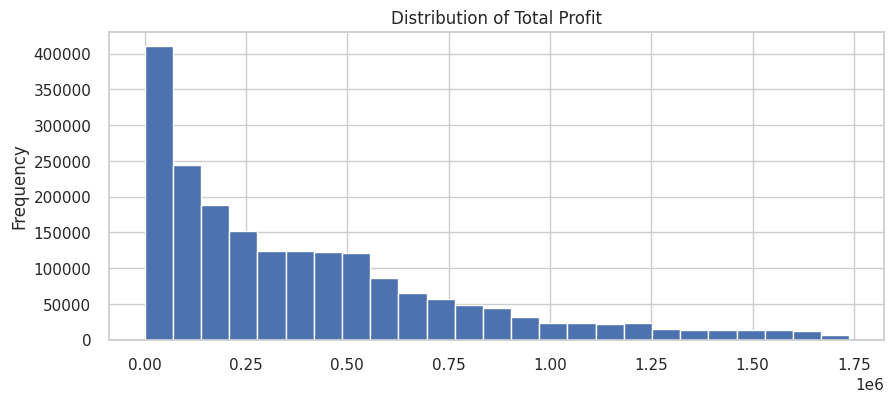

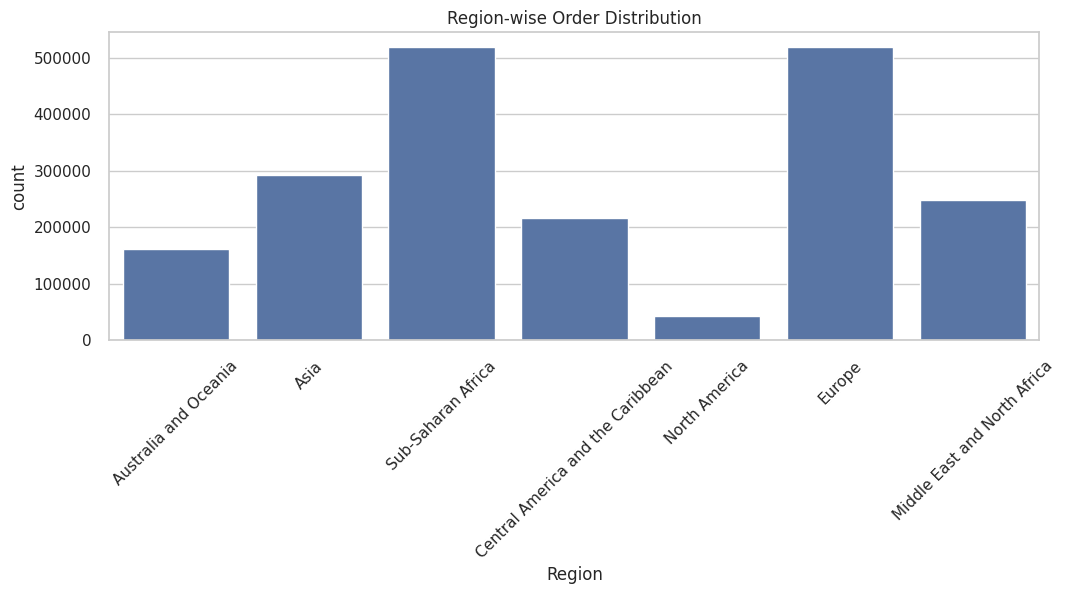

In [3]:
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
import pandas as pd

print(df.shape)
# Preview
display(df.head())

# Summary
display(df.describe().T)

# Correlation
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Distribution plot
df['Total Profit'].plot(kind='hist', bins=25, figsize=(10,4), title="Distribution of Total Profit")
plt.show()

# Region-wise distribution
plt.figure(figsize=(12,4))
sns.countplot(x=df['Region'])
plt.xticks(rotation=45)
plt.title("Region-wise Order Distribution")
plt.show()


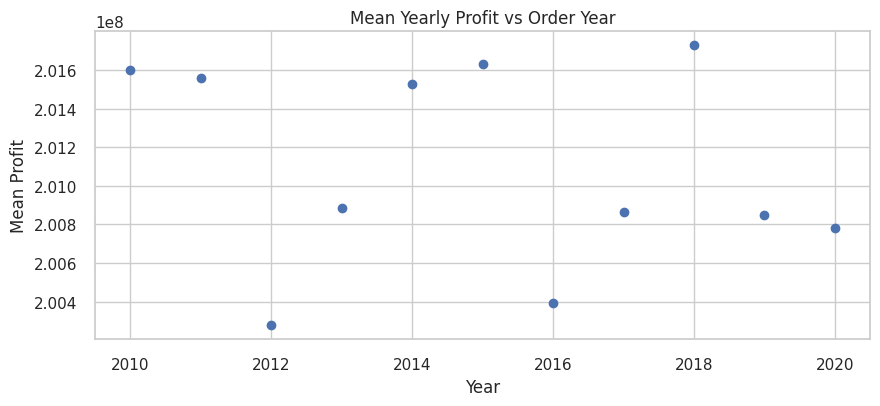

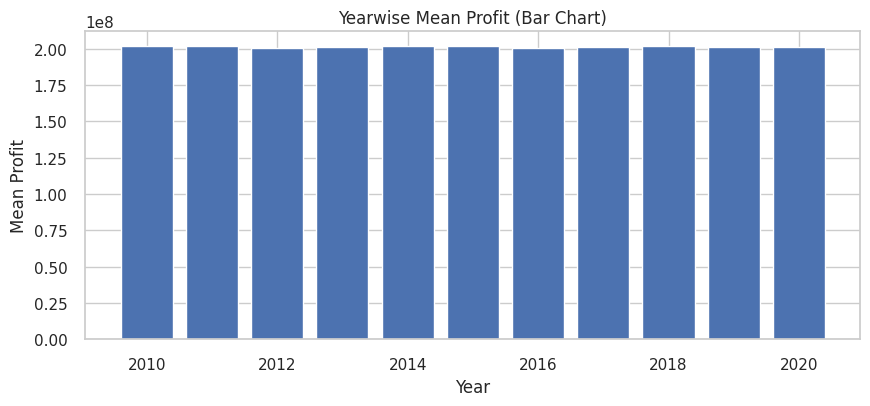

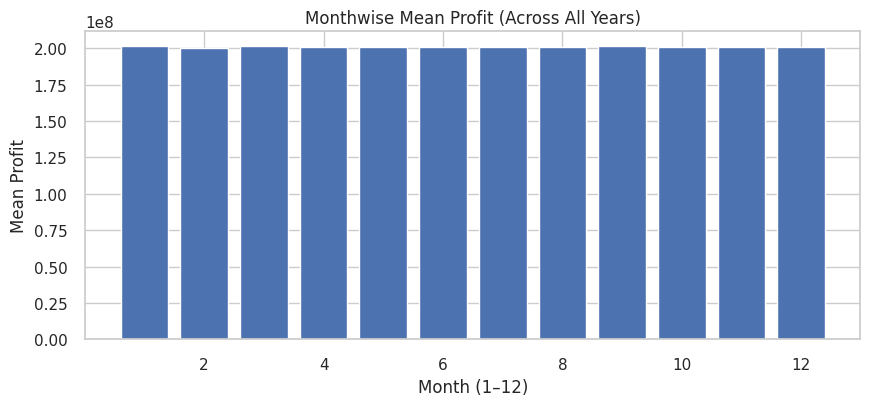

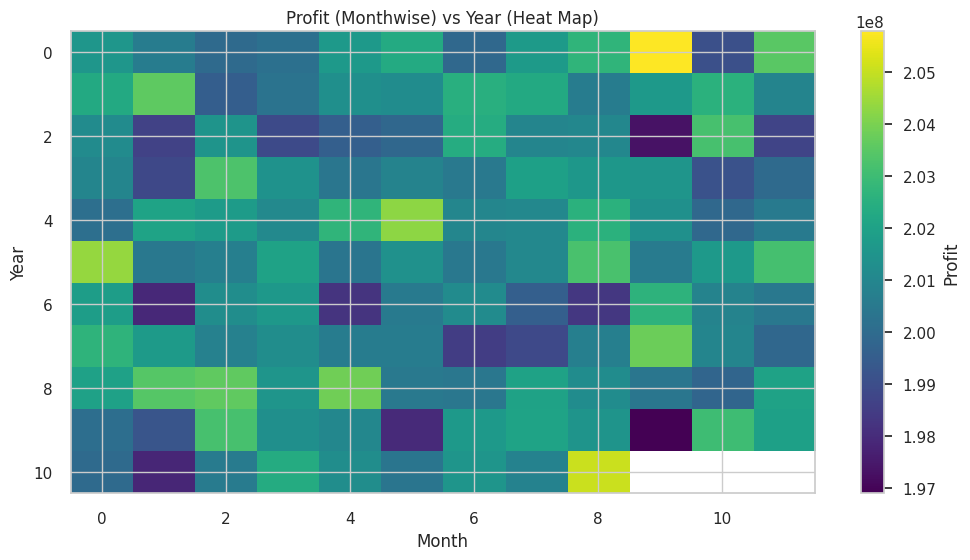

In [4]:
plt.figure(figsize=(10,4))
plt.scatter(yearly_profit["Year"], yearly_profit["Total Profit"])
plt.title("Mean Yearly Profit vs Order Year")
plt.xlabel("Year")
plt.ylabel("Mean Profit")
plt.grid(True)
plt.show()

# ----- Yearly bar graph -----
plt.figure(figsize=(10,4))
plt.bar(yearly_profit["Year"], yearly_profit["Total Profit"])
plt.title("Yearwise Mean Profit (Bar Chart)")
plt.xlabel("Year")
plt.ylabel("Mean Profit")
plt.show()

# ----- Monthwise bar graph -----
plt.figure(figsize=(10,4))
plt.bar(monthwise_profit["Month"], monthwise_profit["Total Profit"])
plt.title("Monthwise Mean Profit (Across All Years)")
plt.xlabel("Month (1–12)")
plt.ylabel("Mean Profit")
plt.show()

# ----- Monthwise Heat Plot (fig 4 style) -----
pivot = daily_profit.pivot_table(
    index="Year",
    columns="Month",
    values="Total Profit",
    aggfunc="mean"
)

plt.figure(figsize=(12,6))
plt.imshow(pivot, aspect="auto", cmap="viridis")
plt.colorbar(label="Profit")
plt.title("Profit (Monthwise) vs Year (Heat Map)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()

/tmp/ipython-input-981676895.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = daily_ts.resample("M").sum()


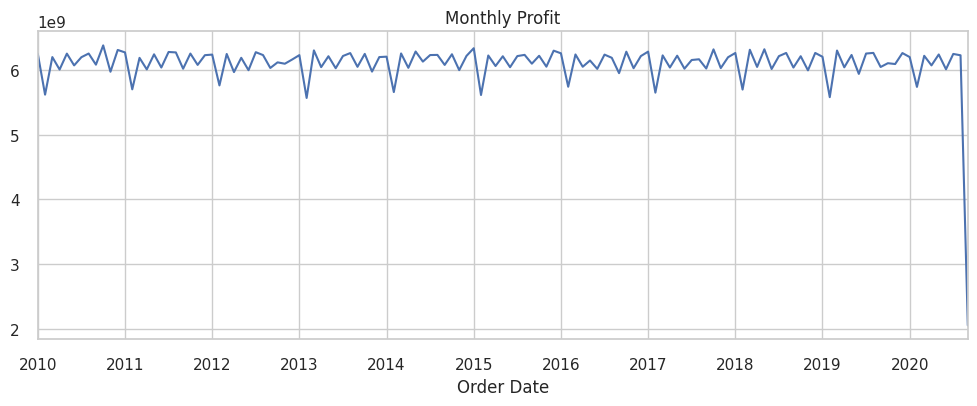

In [5]:
ts = daily_ts.resample("M").sum()

# Plot monthly profit
ts.plot(figsize=(12,4), title="Monthly Profit")
plt.show()

series = ts.values.astype(float)
dates = ts.index

# **TEST/TRAIN**

In [6]:
series = monthly["profit"].values
dates = monthly.index

n = len(series)
n_train = int(n * 0.8)
n_val = int(n * 0.1)
n_test = n - (n_train + n_val)

if n_train <= 0:
    raise ValueError("Not enough data for chosen train/val/test split. Reduce n_val/n_test.")

train_series = series[:n_train]
val_series   = series[n_train:n_train + n_val]
test_series  = series[n_train + n_val:]

train_dates = dates[:n_train]
val_dates   = dates[n_train:n_train + n_val]
test_dates  = dates[n_train + n_val:]

print(f"Train size: {len(train_series)}, Val size: {len(val_series)}, Test size: {len(test_series)}")


Train size: 103, Val size: 12, Test size: 14


# **RMSE**

In [7]:
def mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps)))

def accuracy_from_mape(y_true, y_pred):
    return (1 - mape(y_true, y_pred)) * 100

def print_metrics(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape_val = mape(y_true, y_pred)
    acc = accuracy_from_mape(y_true, y_pred)
    print(f"\n{name} performance on TEST:")
    print(f"  RMSE  : {rmse:.4f}")
    print(f"  MAPE  : {mape_val:.4f}")
    print(f"  ACC%  : {acc:.2f}%")

### **ARIMA MODEL**

In [8]:
from statsmodels.tsa.stattools import adfuller, kpss

# Combine train + val **with proper datetime index**
full_train_len = len(train_series) + len(val_series)
train_val_index = pd.to_datetime(dates[:full_train_len])

# This series will be used for ARIMA & SARIMA
arima_train_series = pd.Series(
    np.concatenate([train_series, val_series]),
    index=train_val_index
)

ts = arima_train_series  # for ADF/KPSS below

# ---------- ADF ----------
adf_stat, adf_pvalue, _, _, adf_crit, _ = adfuller(ts)

print("\n=== ADF Test BEFORE Differencing ===")
print(f"ADF Statistic      : {adf_stat:.4f}")
print(f"p-value            : {adf_pvalue:.4f}")
print("Critical Values    :")
for level, value in adf_crit.items():
    print(f"   {level} : {value:.4f}")

# ---------- KPSS ----------
kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')

print("\n=== KPSS Test BEFORE Differencing ===")
print(f"KPSS Statistic     : {kpss_stat:.4f}")
print(f"p-value            : {kpss_pvalue:.4f}")
print("Critical Values    :")
for level, value in kpss_crit.items():
    print(f"   {level} : {value:.4f}")



=== ADF Test BEFORE Differencing ===
ADF Statistic      : -2.1316
p-value            : 0.2320
Critical Values    :
   1% : -3.4955
   5% : -2.8900
   10% : -2.5820

=== KPSS Test BEFORE Differencing ===
KPSS Statistic     : 0.0322
p-value            : 0.1000
Critical Values    :
   10% : 0.3470
   5% : 0.4630
   2.5% : 0.5740
   1% : 0.7390


/tmp/ipython-input-1077681431.py:26: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts, regression='c', nlags='auto')


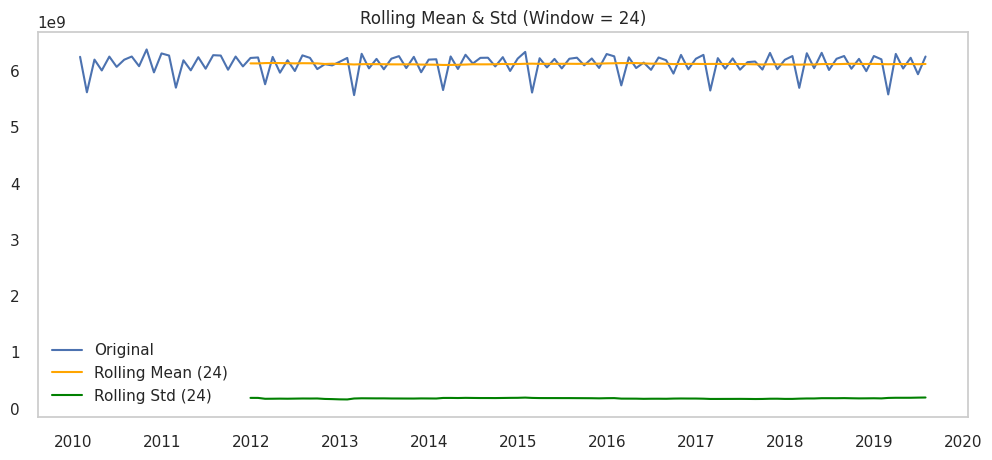

In [9]:
#arima_train_series = pd.Series(arima_train, index=pd.to_datetime(dates[:len(arima_train)]))

roll_mean = arima_train_series.rolling(24).mean()
roll_std  = arima_train_series.rolling(24).std()

plt.figure(figsize=(12,5))
plt.plot(arima_train_series, label="Original")
plt.plot(roll_mean, label="Rolling Mean (24)", color='orange')
plt.plot(roll_std, label="Rolling Std (24)", color='green')
plt.title("Rolling Mean & Std (Window = 24)")
plt.legend()
plt.grid()
plt.show()


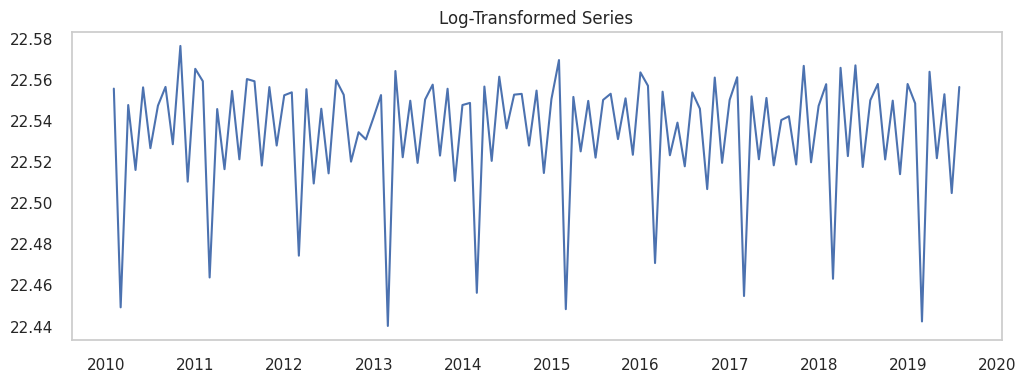

In [10]:
ts_log = np.log(arima_train_series)

plt.figure(figsize=(12,4))
plt.plot(ts_log)
plt.title("Log-Transformed Series")
plt.grid()
plt.show()


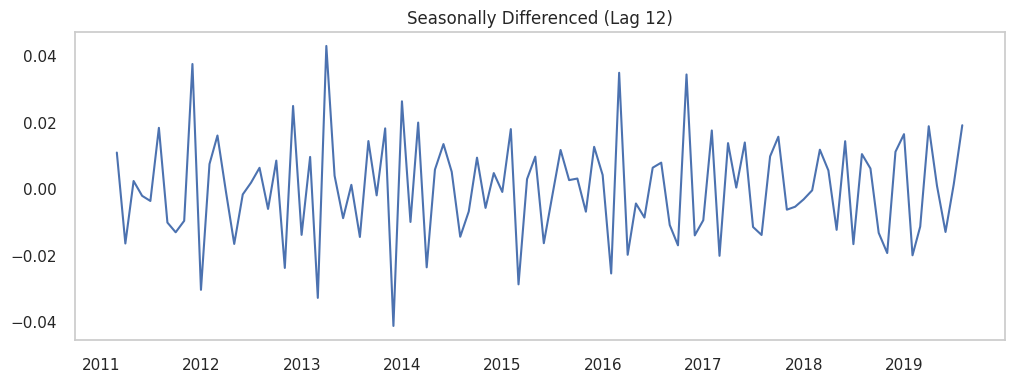

In [11]:
ts_log_diff1 = ts_log.diff().dropna()
ts_log_diff_seasonal = ts_log_diff1.diff(12).dropna()

plt.figure(figsize=(12,4))
plt.plot(ts_log_diff_seasonal)
plt.title("Seasonally Differenced (Lag 12)")
plt.grid()
plt.show()


In [12]:
adf_stat2, adf_pvalue2, _, _, adf_crit2, _ = adfuller(ts_log_diff_seasonal)

print("\n\n=== ADF Test AFTER Differencing ===")
print(f"ADF Statistic      : {adf_stat2:.4f}")
print(f"p-value            : {adf_pvalue2:.4f}")
print("Critical Values    :")
for level, value in adf_crit2.items():
    print(f"   {level} : {value:.4f}")

# ---------- KPSS ----------
kpss_stat2, kpss_pvalue2, _, kpss_crit2 = kpss(ts_log_diff_seasonal, regression='c', nlags='auto')

print("\n=== KPSS Test AFTER Differencing ===")
print(f"KPSS Statistic     : {kpss_stat2:.4f}")
print(f"p-value            : {kpss_pvalue2:.4f}")
print("Critical Values    :")
for level, value in kpss_crit2.items():
    print(f"   {level} : {value:.4f}")



=== ADF Test AFTER Differencing ===
ADF Statistic      : -9.0004
p-value            : 0.0000
Critical Values    :
   1% : -3.4989
   5% : -2.8915
   10% : -2.5828

=== KPSS Test AFTER Differencing ===
KPSS Statistic     : 0.2005
p-value            : 0.1000
Critical Values    :
   10% : 0.3470
   5% : 0.4630
   2.5% : 0.5740
   1% : 0.7390


/tmp/ipython-input-609400644.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat2, kpss_pvalue2, _, kpss_crit2 = kpss(ts_log_diff_seasonal, regression='c', nlags='auto')


<Figure size 1200x400 with 0 Axes>

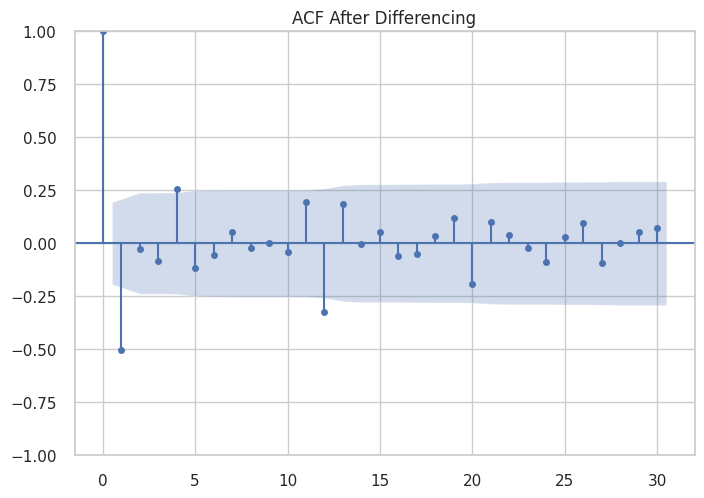

<Figure size 1200x400 with 0 Axes>

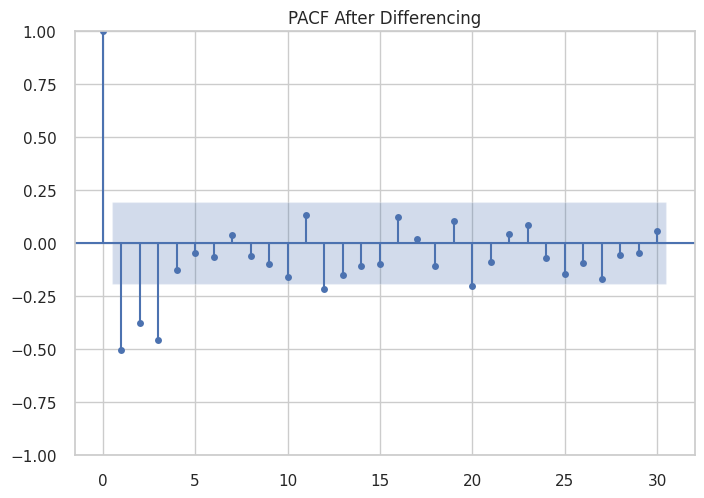

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
max_lags = min(30, len(ts_log_diff_seasonal)//2 - 1)

plt.figure(figsize=(12,4))
plot_acf(ts_log_diff_seasonal, lags=max_lags)
plt.title("ACF After Differencing")
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(ts_log_diff_seasonal, lags=max_lags, method='ywm')
plt.title("PACF After Differencing")
plt.show()


In [14]:
from statsmodels.tsa.arima.model import ARIMA

arima_order = (2, 1, 2)

print("\nFitting ARIMA model...")
arima_model = ARIMA(arima_train_series, order=arima_order)
arima_result = arima_model.fit()

print(arima_result.summary())



Fitting ARIMA model...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  115
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2396.229
Date:                Sat, 29 Nov 2025   AIC                           4802.457
Time:                        04:49:20   BIC                           4816.138
Sample:                    01-31-2010   HQIC                          4808.010
                         - 07-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3309      0.095    -14.030      0.000      -1.517      -1.145
ar.L2         -0.3317      0.093     -3.548      0.000      -0.515      -0.149
ma.L1          1.1373      0.101     11.264      0.0

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [15]:
steps_test = len(test_series)
steps_future = 60   # 60 months = 5 years

arima_forecast_full = arima_result.forecast(steps=steps_test + steps_future)

arima_test_pred = arima_forecast_full[:steps_test]
arima_future_pred = arima_forecast_full[steps_test:]

print_metrics("ARIMA", test_series, arima_test_pred)



ARIMA performance on TEST:
  RMSE  : 138756087.7795
  MAPE  : 0.0162
  ACC%  : 98.38%


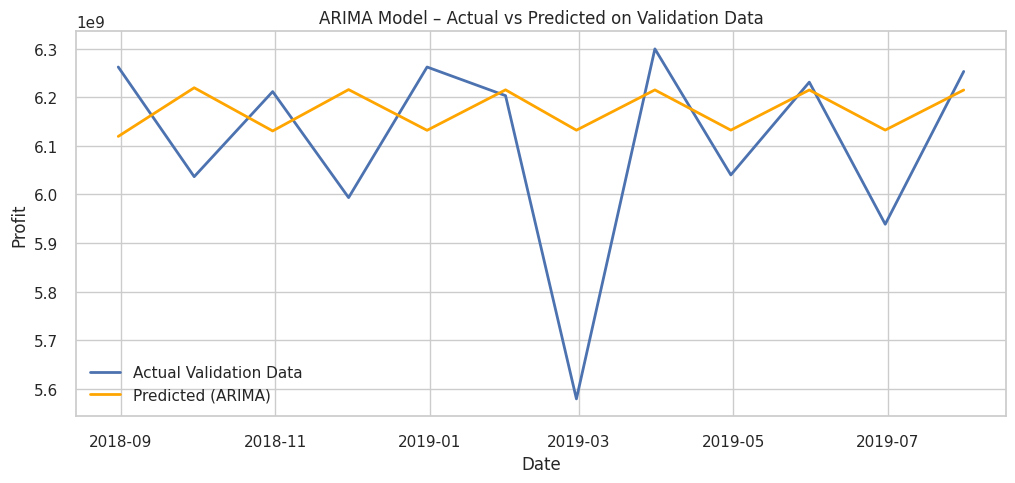

In [16]:
steps_val = len(val_series)

# predict next len(val) points after train+val start
arima_val_pred = arima_result.forecast(steps=steps_val)

plt.figure(figsize=(12,5))
plt.plot(val_dates, val_series, label="Actual Validation Data", linewidth=2)
plt.plot(val_dates, arima_val_pred, label="Predicted (ARIMA)", linewidth=2, color='orange')
plt.title("ARIMA Model – Actual vs Predicted on Validation Data")
plt.xlabel("Date")
plt.ylabel("Profit")
plt.legend()
plt.grid(True)
plt.show()


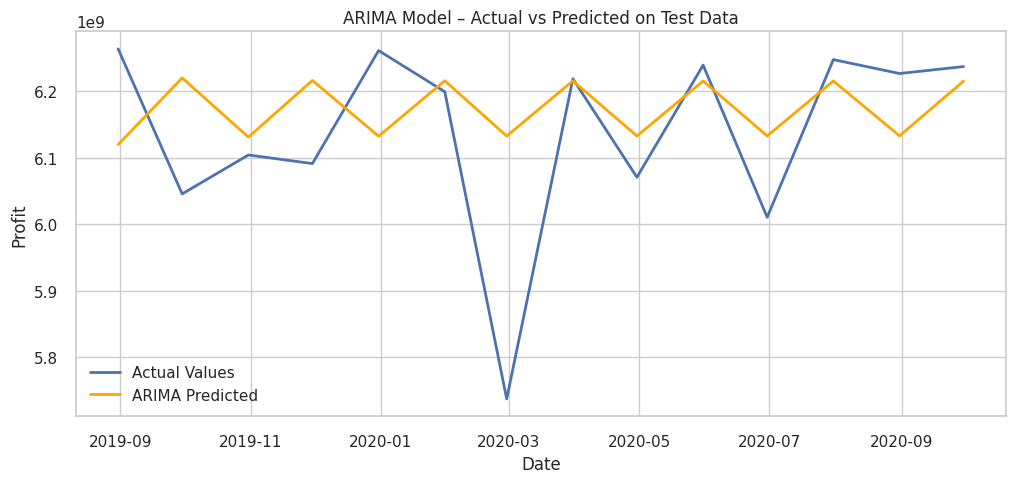

In [17]:
plt.figure(figsize=(12,5))

plt.plot(test_dates, test_series, label="Actual Values", linewidth=2)
plt.plot(test_dates, arima_test_pred, label="ARIMA Predicted", linewidth=2, color='orange')

plt.title("ARIMA Model – Actual vs Predicted on Test Data")
plt.xlabel("Date")
plt.ylabel("Profit")
plt.legend()
plt.grid(True)

plt.show()


/tmp/ipython-input-4047115292.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=test_dates[-1] + pd.offsets.MonthEnd(1),


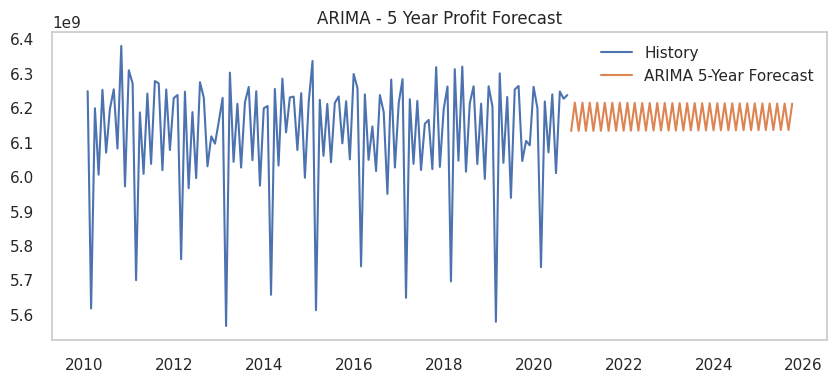

In [18]:
future_dates = pd.date_range(start=test_dates[-1] + pd.offsets.MonthEnd(1),
                             periods=steps_future,
                             freq="M")

plt.figure(figsize=(10,4))
plt.plot(dates, series, label="History")
plt.plot(future_dates, arima_future_pred, label="ARIMA 5-Year Forecast")
plt.title("ARIMA - 5 Year Profit Forecast")
plt.legend()
plt.grid()
plt.show()


### **SARIMA**

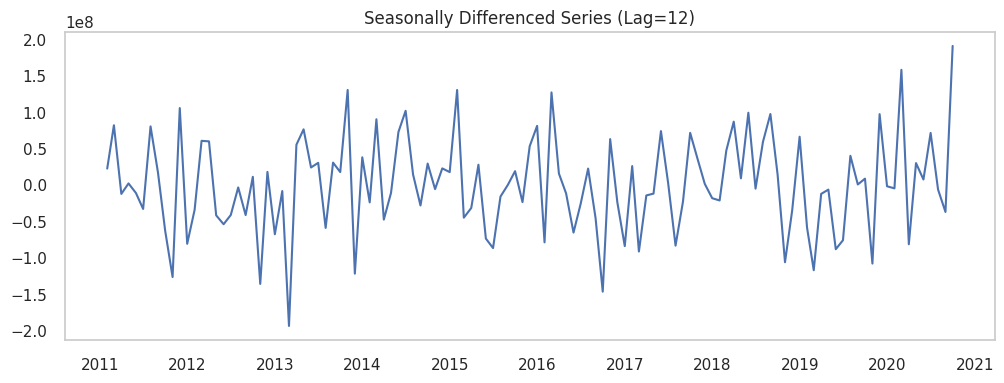

In [19]:
ts_full = pd.Series(series, index=pd.to_datetime(dates))

ts_seasonal_diff = ts_full.diff(12).dropna()

plt.figure(figsize=(12,4))
plt.plot(ts_seasonal_diff)
plt.title("Seasonally Differenced Series (Lag=12)")
plt.grid()
plt.show()

<Figure size 1200x400 with 0 Axes>

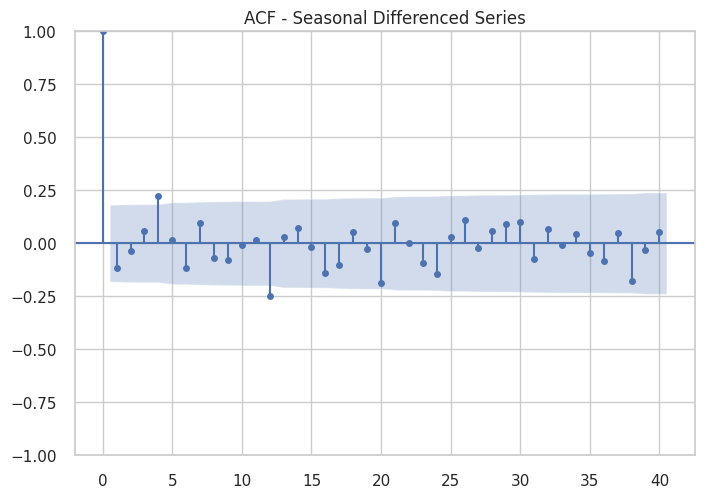

<Figure size 1200x400 with 0 Axes>

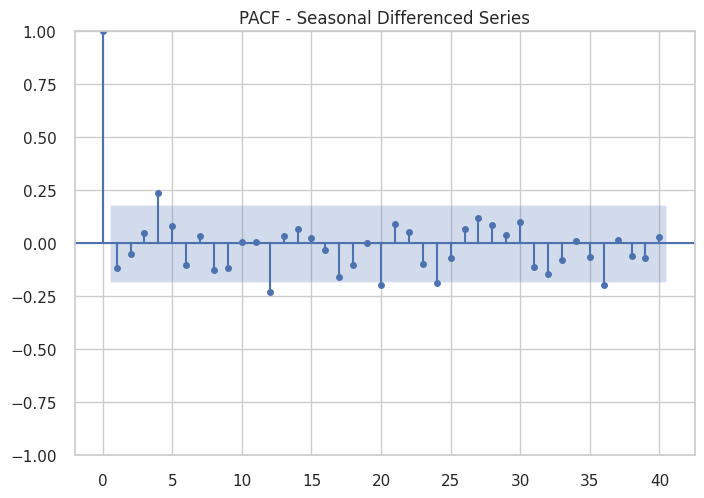

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

max_lags = min(40, len(ts_seasonal_diff)//2 - 1)

plt.figure(figsize=(12,4))
plot_acf(ts_seasonal_diff, lags=max_lags)
plt.title("ACF - Seasonal Differenced Series")
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(ts_seasonal_diff, lags=max_lags, method='ywm')
plt.title("PACF - Seasonal Differenced Series")
plt.show()

In [21]:
sarima_order = (2, 1, 4)
sarima_seasonal = (0, 1, 1, 12)

print("\nFitting SARIMA model...")

sarima_model = sm.tsa.statespace.SARIMAX(
    arima_train_series,
    order=sarima_order,
    seasonal_order=sarima_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_result = sarima_model.fit(disp=False)
print(sarima_result.summary())


Fitting SARIMA model...
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  115
Model:             SARIMAX(2, 1, 4)x(0, 1, [1], 12)   Log Likelihood               -1646.930
Date:                              Sat, 29 Nov 2025   AIC                           3309.861
Time:                                      04:49:22   BIC                           3329.402
Sample:                                  01-31-2010   HQIC                          3317.721
                                       - 07-31-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7000      0.174     -4.022      0.000      -1.041      -

In [22]:
sarima_forecast_full = sarima_result.forecast(steps=steps_test + steps_future)

sarima_test_pred = sarima_forecast_full[:steps_test]
sarima_future_pred = sarima_forecast_full[steps_test:]

print_metrics("SARIMA", test_series, sarima_test_pred)


SARIMA performance on TEST:
  RMSE  : 103608191.6836
  MAPE  : 0.0131
  ACC%  : 98.69%


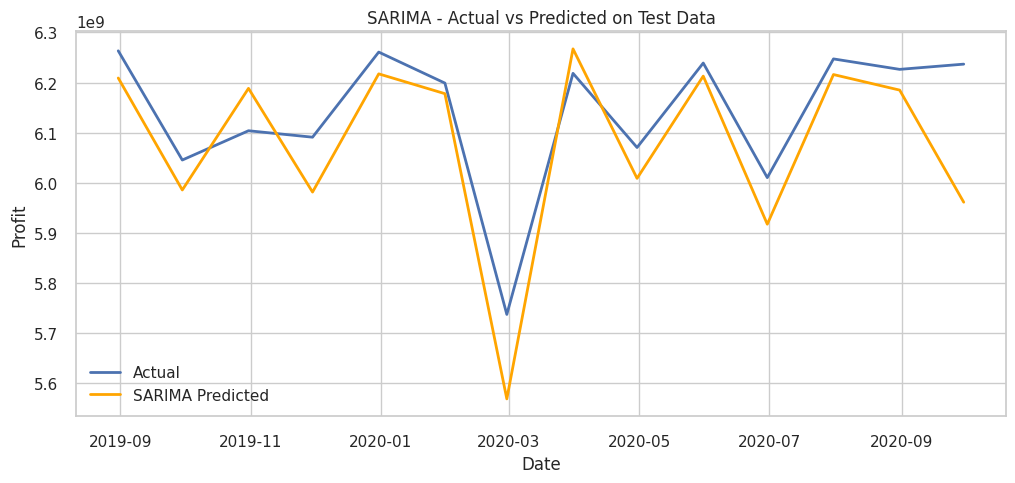

In [23]:
plt.figure(figsize=(12,5))
plt.plot(test_dates, test_series, label="Actual", linewidth=2)
plt.plot(test_dates, sarima_test_pred, label="SARIMA Predicted", linewidth=2, color='orange')
plt.title("SARIMA - Actual vs Predicted on Test Data")
plt.xlabel("Date")
plt.ylabel("Profit")
plt.legend()
plt.grid(True)
plt.show()

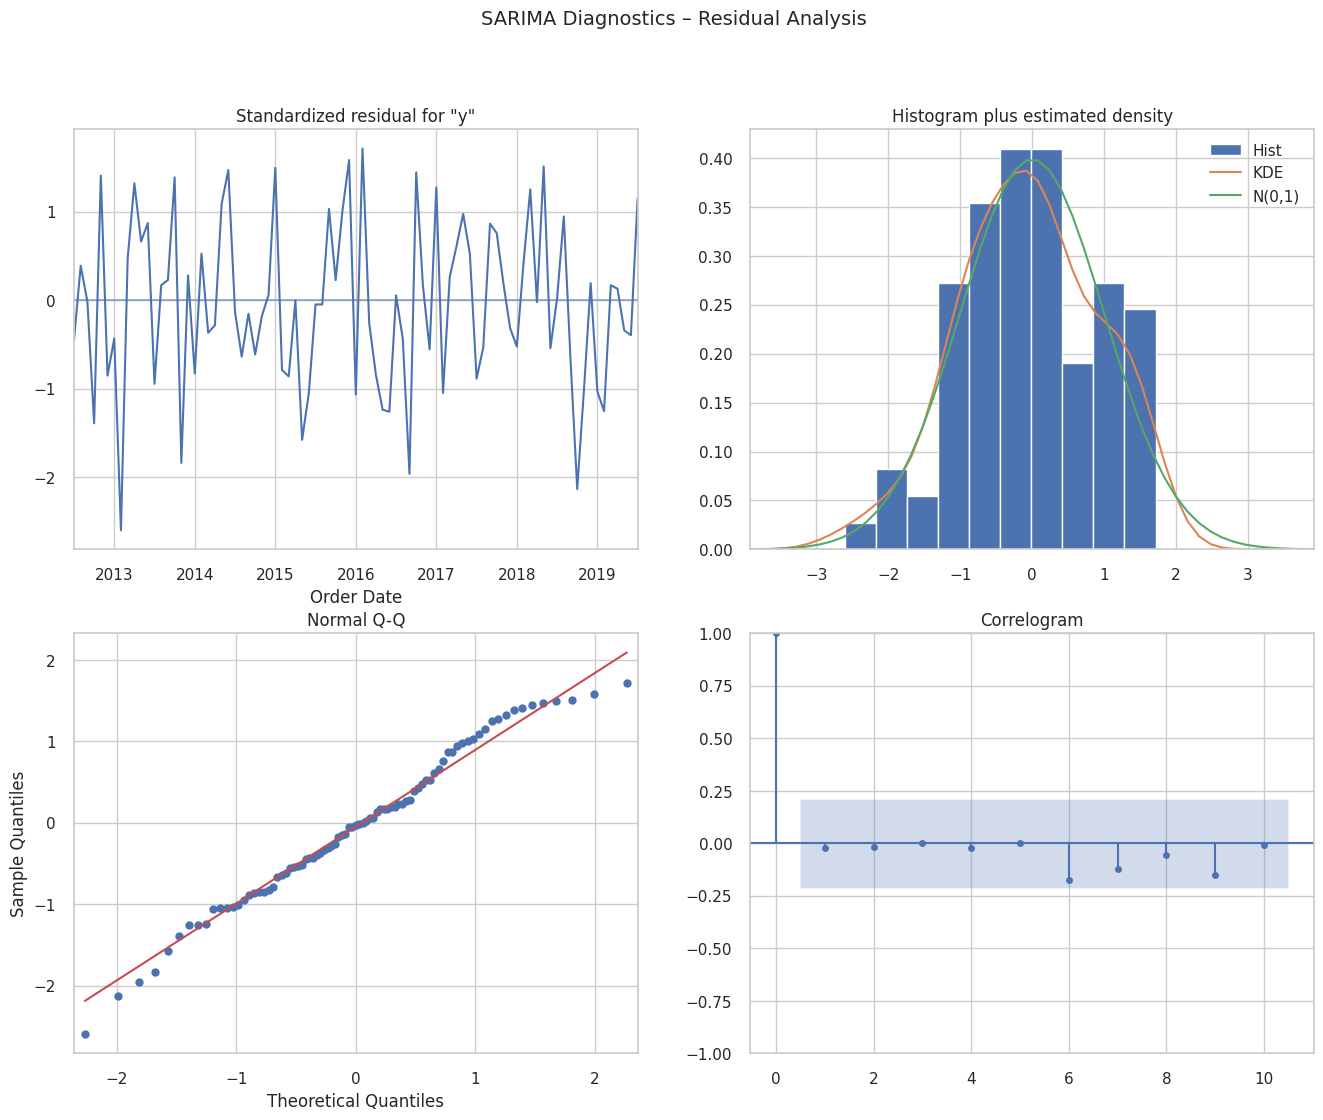

In [24]:
sarima_result.plot_diagnostics(figsize=(16,12))
plt.suptitle("SARIMA Diagnostics – Residual Analysis", fontsize=14)
plt.show()

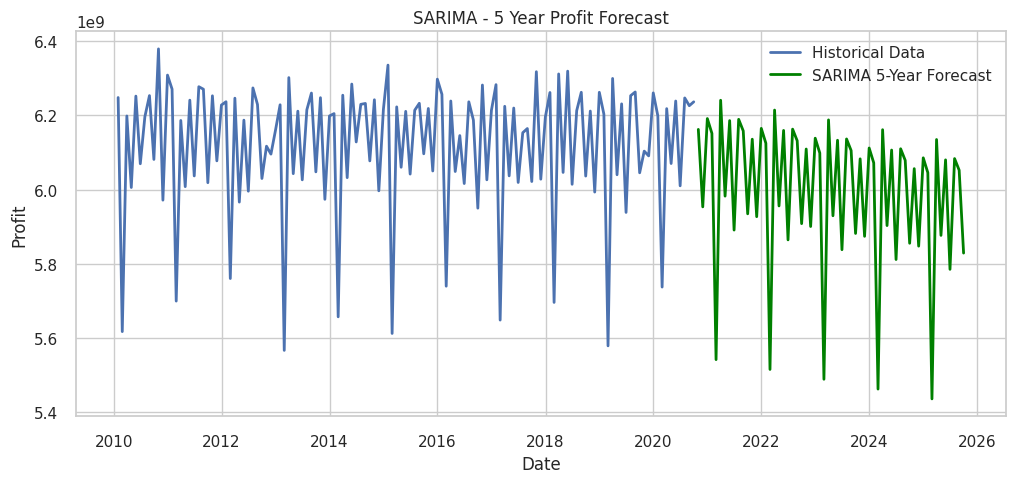

In [25]:
plt.figure(figsize=(12,5))
plt.plot(dates, series, label="Historical Data", linewidth=2)
plt.plot(future_dates, sarima_future_pred, label="SARIMA 5-Year Forecast", linewidth=2, color='green')
plt.title("SARIMA - 5 Year Profit Forecast")
plt.xlabel("Date")
plt.ylabel("Profit")
plt.legend()
plt.grid(True)
plt.show()

## **LSTM MODEL**

In [26]:
import tensorflow as tf
import numpy as np
import random
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series.reshape(-1,1)).astype(np.float32)

train_scaled = series_scaled[:n_train]
val_scaled   = series_scaled[n_train:n_train + n_val]
test_scaled  = series_scaled[n_train + n_val:]

SEQ_LEN = 12
BATCH_SIZE = 16

# ---- Build tf datasets ----
def make_tf_dataset(data_scaled, seq_len, batch_size):
    x = data_scaled[:-1]
    y = data_scaled[1:]
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=x,
        targets=y,
        sequence_length=seq_len,
        batch_size=batch_size,
        shuffle=False
    )
    return ds

train_ds = make_tf_dataset(train_scaled, SEQ_LEN, BATCH_SIZE)
val_ds   = make_tf_dataset(np.concatenate([train_scaled[-SEQ_LEN:], val_scaled]),
                           SEQ_LEN, BATCH_SIZE)
test_ds  = make_tf_dataset(
              np.concatenate([train_scaled[-SEQ_LEN - n_val:],
                              val_scaled,
                              test_scaled]),
              SEQ_LEN, BATCH_SIZE)

In [27]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(SEQ_LEN, 1)),
    tf.keras.layers.LSTM(100, activation="tanh"),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer="adam", loss="mse")

EPOCHS = 25
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, verbose=1)

Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.3382 - val_loss: 0.0752
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0648 - val_loss: 0.0791
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0744 - val_loss: 0.0565
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0578 - val_loss: 0.0658
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0578 - val_loss: 0.0505
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0513 - val_loss: 0.0506
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0540 - val_loss: 0.0499
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0513 - val_loss: 0.0523
Epoch 9/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0514 - val_loss: 0.0503
Epoch 10/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0509 - val_loss: 0.0495
Epoch 11/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0513 - val_loss: 0.0499
Epoch 12/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0510 - val_loss: 0.0504


In [28]:
lstm_preds_scaled = model.predict(test_ds).flatten()
lstm_test_pred = scaler.inverse_transform(lstm_preds_scaled.reshape(-1,1)).flatten()

# -----------------------------------------------------
# 6. ALIGN LENGTH WITH TEST SERIES
# -----------------------------------------------------
test_series_unscaled = series[n_train + n_val:]
lstm_test_pred = lstm_test_pred[:len(test_series_unscaled)]

# -----------------------------------------------------
# 7. METRICS (ORIGINAL ACCURACY)
# -----------------------------------------------------
print_metrics("LSTM", test_series_unscaled, lstm_test_pred)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step

LSTM performance on TEST:
  RMSE  : 142898497.5964
  MAPE  : 0.0186
  ACC%  : 98.14%


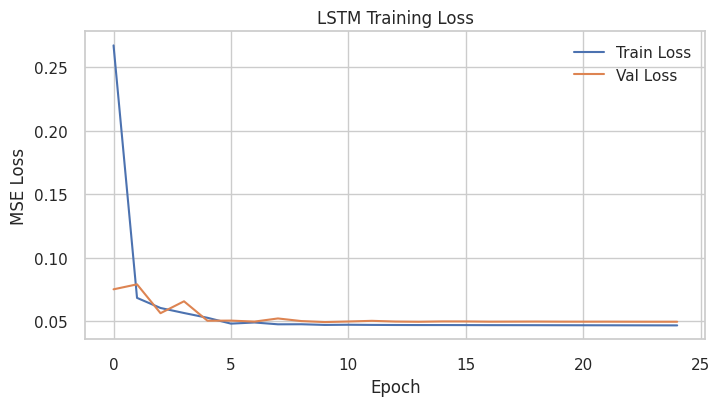

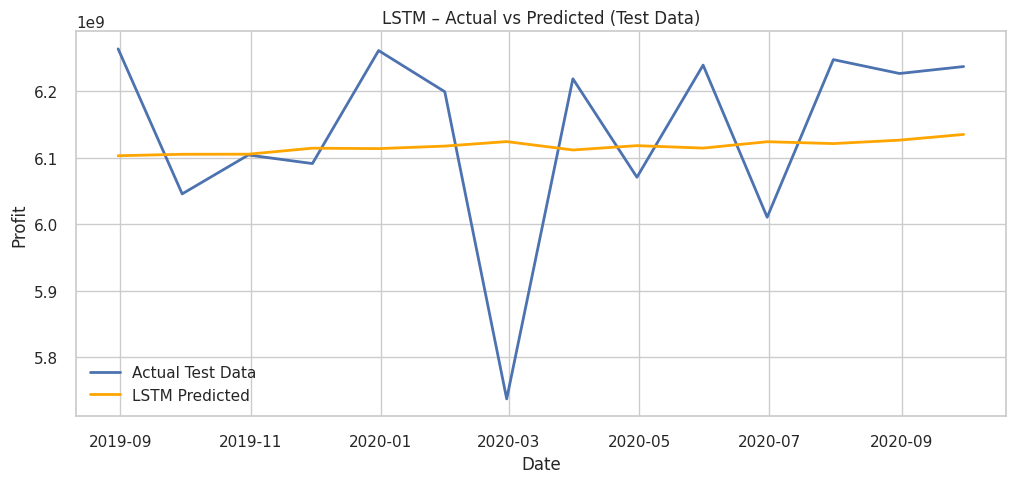

In [29]:
plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("LSTM Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(test_dates, test_series_unscaled, label="Actual Test Data", linewidth=2)
plt.plot(test_dates, lstm_test_pred, label="LSTM Predicted", linewidth=2, color='orange')
plt.title("LSTM – Actual vs Predicted (Test Data)")
plt.xlabel("Date")
plt.ylabel("Profit")
plt.legend()
plt.grid(True)
plt.show()

## **EVALUATE ON TEST**

In [30]:
full_scaled_for_test = series_scaled[n_train + n_val - SEQ_LEN:]  # so that test labels appear at the end

ds_test_eval = timeseries_dataset_from_array(
    data=full_scaled_for_test[:-1],
    targets=full_scaled_for_test[1:],
    sequence_length=SEQ_LEN,
    batch_size=1,
    shuffle=False
)

pred_scaled_list = []
true_scaled_list = []

for X_batch, y_batch in ds_test_eval:
    pred = model.predict(X_batch, verbose=0)
    pred_scaled_list.append(pred[0,0])
    true_scaled_list.append(y_batch[0,0])

pred_scaled = np.array(pred_scaled_list)
true_scaled = np.array(true_scaled_list)

# Map these predictions to the last len(test_series) points
pred_scaled_test = pred_scaled[-len(test_series):]
true_scaled_test = true_scaled[-len(test_series):]

# Inverse scale
pred_test = scaler.inverse_transform(pred_scaled_test.reshape(-1,1)).flatten()
true_test = scaler.inverse_transform(true_scaled_test.reshape(-1,1)).flatten()

print_metrics("LSTM", test_series_unscaled, lstm_test_pred)


LSTM performance on TEST:
  RMSE  : 142898497.5964
  MAPE  : 0.0186
  ACC%  : 98.14%


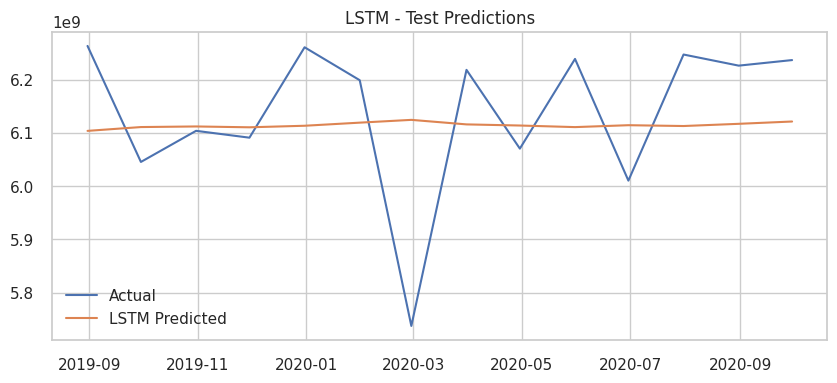

In [31]:
plt.figure(figsize=(10,4))
plt.plot(test_dates, test_series, label="Actual")
plt.plot(test_dates, pred_test, label="LSTM Predicted")
plt.title("LSTM - Test Predictions")
plt.legend()
plt.show()

In [32]:
last_seq = series_scaled[-SEQ_LEN:].copy()
future_lstm_scaled = []

for _ in range(steps_future):
    input_seq = last_seq.reshape(1, SEQ_LEN, 1)
    pred_next = model.predict(input_seq, verbose=0)[0,0]
    future_lstm_scaled.append(pred_next)
    # slide window
    last_seq = np.concatenate([last_seq[1:], np.array([[pred_next]])], axis=0)

future_lstm_scaled = np.array(future_lstm_scaled)
future_lstm = scaler.inverse_transform(future_lstm_scaled.reshape(-1,1)).flatten()

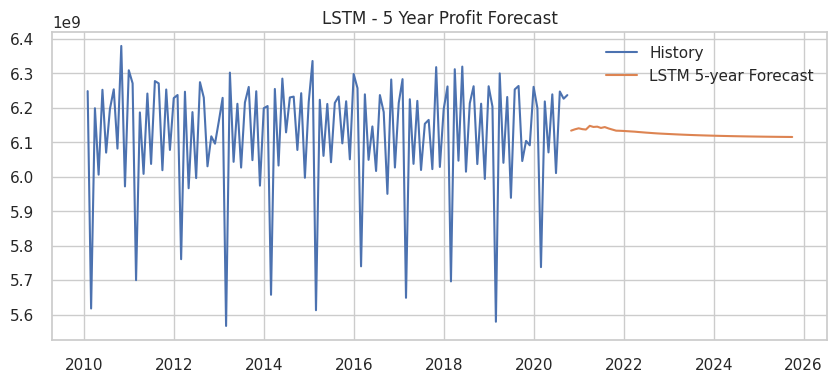

In [33]:
plt.figure(figsize=(10,4))
plt.plot(dates, series, label="History")
plt.plot(future_dates, future_lstm, label="LSTM 5-year Forecast")
plt.title("LSTM - 5 Year Profit Forecast")
plt.legend()
plt.show()

/tmp/ipython-input-1342568156.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(dates[-1] + pd.offsets.MonthEnd(1), periods=60, freq="M")


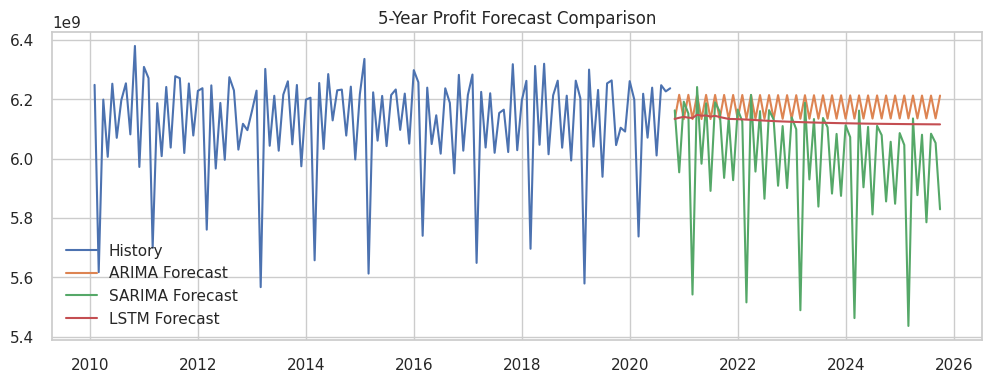

In [34]:
future_dates = pd.date_range(dates[-1] + pd.offsets.MonthEnd(1), periods=60, freq="M")

plt.figure(figsize=(12,4))
plt.plot(dates, series, label="History")
plt.plot(future_dates, arima_future_pred, label="ARIMA Forecast")
plt.plot(future_dates, sarima_future_pred, label="SARIMA Forecast")
plt.plot(future_dates, future_lstm, label="LSTM Forecast")
plt.legend()
plt.title("5-Year Profit Forecast Comparison")
plt.show()

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from scipy.stats import pearsonr

# --- MAPE ---
def mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps)))

# --- MPE (Mean Percentage Error) ---
def mpe(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean((y_true - y_pred) / (y_true + eps))

# --- Min–Max Error ---
def minmax_error(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs(y_true - y_pred) / (np.max(y_true) - np.min(y_true) + eps))

# --- Correlation ---
def corr(y_true, y_pred):
    return pearsonr(y_true, y_pred)[0]

# --- Accuracy from MAPE ---
def accuracy_from_mape(y_true, y_pred):
    return (1 - mape(y_true, y_pred)) * 100


In [36]:
def compute_all_metrics(y_true, y_pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MAPE": mape(y_true, y_pred),
        "MPE": mpe(y_true, y_pred),
        "MinMaxError": minmax_error(y_true, y_pred),
        "Accuracy (%)": accuracy_from_mape(y_true, y_pred)
    }


In [37]:
y_test = test_series_unscaled


In [38]:
print_metrics("ARIMA", y_test, arima_test_pred)
print_metrics("SARIMA", y_test, sarima_test_pred)
print_metrics("LSTM", y_test, lstm_test_pred)



ARIMA performance on TEST:
  RMSE  : 138756087.7795
  MAPE  : 0.0162
  ACC%  : 98.38%

SARIMA performance on TEST:
  RMSE  : 103608191.6836
  MAPE  : 0.0131
  ACC%  : 98.69%

LSTM performance on TEST:
  RMSE  : 142898497.5964
  MAPE  : 0.0186
  ACC%  : 98.14%


In [39]:
metrics_arima  = compute_all_metrics(y_test, arima_test_pred)
metrics_sarima = compute_all_metrics(y_test, sarima_test_pred)
metrics_lstm   = compute_all_metrics(y_test, lstm_test_pred)

metrics_df = pd.DataFrame([
    {"Model": "ARIMA",  **metrics_arima},
    {"Model": "SARIMA", **metrics_sarima},
    {"Model": "LSTM",   **metrics_lstm}
])

print(metrics_df)


    Model          RMSE           MAE      MAPE       MPE  MinMaxError  \
0   ARIMA  1.387561e+08  9.771011e+07  0.016226 -0.006018     0.185884   
1  SARIMA  1.036082e+08  7.985392e+07  0.013102  0.010004     0.151914   
2    LSTM  1.428985e+08  1.128651e+08  0.018568  0.003159     0.214715   

   Accuracy (%)  
0     98.377403  
1     98.689770  
2     98.143217  


In [40]:
model.save("lstm_profit_model.h5")
import joblib
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [45]:
!mkdir -p /content/profit_project
!cp "/content/drive/MyDrive/Colab Notebooks/fixed9sem.ipynb" "/content/profit_project/"

%cd /content/profit_project
!ls


/content/profit_project
fixed9sem.ipynb
